In [1]:
import os 
import math
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
import seaborn as sn
%matplotlib inline

data_folder = '../data/'
np.random.seed(2022)

# Data Description
Plot the data points location distribution

In [2]:
columns = ['RELI', 'EAST', 'NORTH']

trainset_data = pd.read_csv(os.path.join(data_folder, 'trainset_with_neighbour.csv'), usecols=columns)
trainset_data.set_index('RELI', inplace=True)
trainset_data.head()

,EAST,NORTH
RELI,,
48561099,2485600,1109900
48611112,2486100,1111200
48621113,2486200,1111300
48621114,2486200,1111400
48621115,2486200,1111500


<AxesSubplot:xlabel='EAST', ylabel='NORTH'>

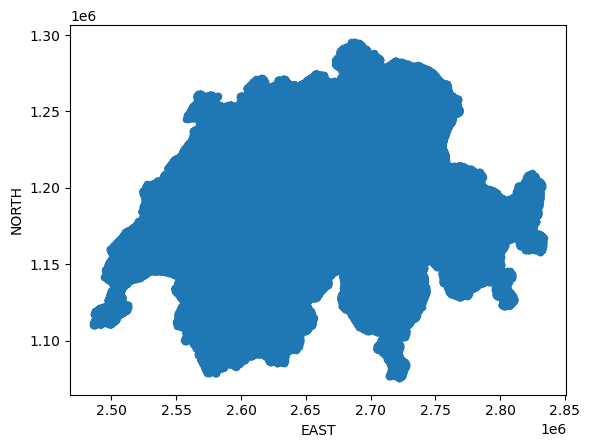

In [3]:
trainset_data.plot(x='EAST', y='NORTH', kind='scatter')

### Neighbor count matrix for Land Usage

<img src='../img/Land_Uasge_matrix.png'>

# Logistic Regression

### A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 
- Standardize the values of each feature in the data to have mean 0 and variance 1.

### 8-neighbors 

In [4]:
columns = ['LU4', 'LC4', 'LU3', 'LC3', 'LU2', 'LC2', 'LU1', 'LC1', 'nbr1_LU3', 'nbr1_LC3', 'nbr1_LU2', 'nbr1_LC2', 'nbr1_LU1',
           'nbr1_LC1', 'nbr2_LU3', 'nbr2_LC3', 'nbr2_LU2', 'nbr2_LC2', 'nbr2_LU1', 'nbr2_LC1', 'nbr3_LU3', 'nbr3_LC3',
           'nbr3_LU2', 'nbr3_LC2', 'nbr3_LU1', 'nbr3_LC1', 'nbr4_LU3', 'nbr4_LC3', 'nbr4_LU2', 'nbr4_LC2', 'nbr4_LU1',
           'nbr4_LC1', 'nbr5_LU3', 'nbr5_LC3', 'nbr5_LU2', 'nbr5_LC2', 'nbr5_LU1', 'nbr5_LC1', 'nbr6_LU3', 'nbr6_LC3',
           'nbr6_LU2', 'nbr6_LC2', 'nbr6_LU1', 'nbr6_LC1', 'nbr7_LU3', 'nbr7_LC3', 'nbr7_LU2', 'nbr7_LC2', 'nbr7_LU1',
           'nbr7_LC1', 'nbr8_LU3', 'nbr8_LC3', 'nbr8_LU2', 'nbr8_LC2', 'nbr8_LU1', 'nbr8_LC1']


### 4-neighbors 

In [ ]:
columns = ['LU4', 'LC4', 'LU3', 'LC3', 'LU2', 'LC2', 'LU1', 'LC1', 'nbr1_LU3', 'nbr1_LC3', 'nbr1_LU2', 'nbr1_LC2', 'nbr1_LU1',
           'nbr1_LC1', 'nbr2_LU3', 'nbr2_LC3', 'nbr2_LU2', 'nbr2_LC2', 'nbr2_LU1', 'nbr2_LC1', 'nbr3_LU3', 'nbr3_LC3',
           'nbr3_LU2', 'nbr3_LC2', 'nbr3_LU1', 'nbr3_LC1', 'nbr4_LU3', 'nbr4_LC3', 'nbr4_LU2', 'nbr4_LC2', 'nbr4_LU1',
           'nbr4_LC1']

### Time-deactivation

In [ ]:
columns = ['LU4', 'LC4', 'LU3', 'LC3', 'nbr1_LU3', 'nbr1_LC3', 'nbr2_LU3', 'nbr2_LC3', 'nbr3_LU3', 'nbr3_LC3',
           'nbr4_LU3', 'nbr4_LC3', 'nbr5_LU3', 'nbr5_LC3', 'nbr6_LU3', 'nbr6_LC3', 'nbr7_LU3', 'nbr7_LC3',
           'nbr8_LU3', 'nbr8_LC3']

### Space-deactivation

In [ ]:
columns = ['LU4', 'LC4', 'LU3', 'LC3', 'LU2', 'LC2', 'LU1', 'LC1']

### Data loading

In [5]:
original_data = pd.read_csv(os.path.join(data_folder, 'trainset_with_neighbour.csv'), index_col=0)
original_data = original_data[columns]
original_data.head()

,LU4,LC4,LU3,LC3,LU2,LC2,LU1,LC1,nbr1_LU3,nbr1_LC3,...,nbr7_LU2,nbr7_LC2,nbr7_LU1,nbr7_LC1,nbr8_LU3,nbr8_LC3,nbr8_LU2,nbr8_LC2,nbr8_LU1,nbr8_LC1
RELI,,,,,,,,,,,,,,,,,,,,,
48561099,LU301,LC41,LU301,LC41,LU301,LC41,LU301,LC41,LU301,LC41,...,LU221,LC21,LU221,LC21,LU301,LC41,LU301,LC41,LU301,LC41
48611112,LU402,LC61,LU402,LC61,LU402,LC61,LU402,LC61,LU402,LC61,...,LU221,LC21,LU221,LC21,LU221,LC21,LU221,LC21,LU221,LC21
48621113,LU103,LC47,LU103,LC47,LU421,LC31,LU421,LC31,LU106,LC12,...,LU222,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61
48621114,LU106,LC12,LU106,LC12,LU106,LC12,LU106,LC12,LU142,LC15,...,LU222,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61
48621115,LU142,LC11,LU142,LC15,LU142,LC15,LU142,LC15,LU402,LC61,...,LU222,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61


In [6]:
print('The length of the data with all rows is : {}'.format(len(original_data)))
original_data.dropna(inplace=True)
print('The length of the data without the rows with nan value is: {}'.format(len(original_data)))

The length of the data with all rows is : 348474
The length of the data without the rows with nan value is: 348474


In [7]:
data_features = original_data.copy()
data_features['changed'] = [0 if row['LU4'] == row['LU3'] and row['LC4'] == row['LC3'] else 1 for ind, row in data_features[['LU4', 'LC4', 'LU3', 'LC3']].iterrows()]
data_features.drop(['LC4', 'LU4'], axis=1, inplace=True)
data_features.head()

,LU3,LC3,LU2,LC2,LU1,LC1,nbr1_LU3,nbr1_LC3,nbr1_LU2,nbr1_LC2,...,nbr7_LC2,nbr7_LU1,nbr7_LC1,nbr8_LU3,nbr8_LC3,nbr8_LU2,nbr8_LC2,nbr8_LU1,nbr8_LC1,changed
RELI,,,,,,,,,,,,,,,,,,,,,
48561099,LU301,LC41,LU301,LC41,LU301,LC41,LU301,LC41,LU301,LC41,...,LC21,LU221,LC21,LU301,LC41,LU301,LC41,LU301,LC41,0
48611112,LU402,LC61,LU402,LC61,LU402,LC61,LU402,LC61,LU402,LC61,...,LC21,LU221,LC21,LU221,LC21,LU221,LC21,LU221,LC21,0
48621113,LU103,LC47,LU421,LC31,LU421,LC31,LU106,LC12,LU106,LC12,...,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61,0
48621114,LU106,LC12,LU106,LC12,LU106,LC12,LU142,LC15,LU142,LC15,...,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61,0
48621115,LU142,LC15,LU142,LC15,LU142,LC15,LU402,LC61,LU402,LC61,...,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61,1


In [8]:
print('Total number of tiles that changed label in either Land Cover or Land Usage: %d' % sum(data_features.changed))

Total number of tiles that changed label in either Land Cover or Land Usage: 58737


In [9]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask], data_to_split[~mask]]

In [10]:
[train, test] = split_set(data_features)

In [11]:
train_categorical = pd.get_dummies(train)
train_categorical.columns

Index(['changed', 'LU3_LU101', 'LU3_LU102', 'LU3_LU103', 'LU3_LU104',
       'LU3_LU105', 'LU3_LU106', 'LU3_LU107', 'LU3_LU108', 'LU3_LU121',
       ...
       'nbr8_LC1_LC45', 'nbr8_LC1_LC46', 'nbr8_LC1_LC47', 'nbr8_LC1_LC51',
       'nbr8_LC1_LC52', 'nbr8_LC1_LC53', 'nbr8_LC1_LC61', 'nbr8_LC1_LC62',
       'nbr8_LC1_LC63', 'nbr8_LC1_LC64'],
      dtype='object', length=1972)

In [12]:
# Make sure we use only the features available in the training set
test_categorical = pd.get_dummies(test)[train_categorical.columns]

In [13]:
train_label=train_categorical.changed
train_features = train_categorical.drop('changed', axis=1)
print('Length of the train dataset : {}'.format(len(train)))

test_label=test_categorical.changed
test_features = test_categorical.drop('changed', axis=1)
print('Length of the test dataset : {}'.format(len(test)))

Length of the train dataset : 278198
Length of the test dataset : 70276


### B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities.
- For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class.

In [14]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
    
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix, thred, axs):
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 
    
    sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='',ax=axs)
    axs.set_xlabel('Actual')
    axs.set_ylabel('Predicted')
    axs.set_title('Confusion matrix for a {} threshold'.format(thred))
    


def compute_all_score(confusion_matrix, t=0.5):
    
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    balanced_acc = (recall_negative + recall_positive) / 2

    return [t, accuracy, balanced_acc, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [15]:
# Load from file
pkl_filename = "./temp_results/logistic_regression_baseline.pkl"
with open(pkl_filename, 'rb') as file:
    logistic = pickle.load(file)

In [ ]:
# vanilla logistics regression 
# logistic = LogisticRegression(solver='sag', max_iter=10000, class_weight='balanced', verbose=1, warm_start=True, n_jobs=-1, multi_class='ovr')
# logistic.fit(train_features,train_label)

In [ ]:
# logistics regression with cross-validation and target score metric 
# (os.cpu_count() - 4)
logistic = LogisticRegressionCV(solver='sag', cv=5, scoring='balanced_accuracy', max_iter=3000, class_weight='balanced', n_jobs= -1, multi_class='ovr')
logistic.fit(train_features,train_label)

In [17]:
prediction_proba = logistic.predict_proba(test_features)

In [40]:
train_proba = logistic.predict_proba(train_features)
train_proba_df = pd.DataFrame(train_proba, index=train.index, columns=['p_unchage', 'p_change'])
train_proba_df = pd.concat([train_proba_df, train_label], axis=1)
test_proba_df = pd.DataFrame(prediction_proba, index=test.index, columns=['p_unchage', 'p_change'])
test_proba_df = pd.concat([test_proba_df, test_label], axis=1)
logreg_proba = pd.concat([train_proba_df, test_proba_df], axis=0)
logreg_proba.sort_index(inplace=True)
logreg_proba = logreg_proba.merge(data_features[['LC3', 'LU3']], on='RELI')
logreg_proba.head()

,p_unchage,p_change,changed,LC3,LU3
RELI,,,,,
48561099,0.319364,0.680636,0,LC41,LU301
48611112,0.847969,0.152031,0,LC61,LU402
48621113,0.356399,0.643601,0,LC47,LU103
48621114,0.876144,0.123856,0,LC12,LU106
48621115,0.339232,0.660768,1,LC15,LU142


In [41]:
with open('./temp_results/logreg_proba.pkl', 'wb') as file:
    pickle.dump(logreg_proba, file)

In [36]:
# Save to file in the current working directory
pkl_filename = "./logistic_regression_baseline.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(logreg_proba, file)

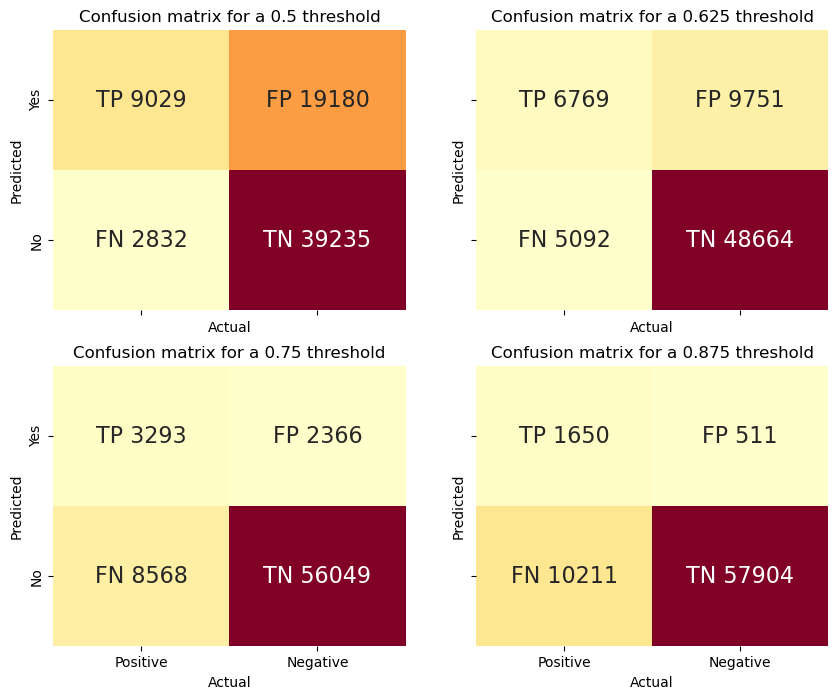

In [18]:
confusion_matrix_ls = []
thred_ls = [0.5, 0.625, 0.75, 0.875]

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,8))

for axe, thred in zip(axs.flat, thred_ls):
    confusion_matrix = compute_confusion_matrix(test_label, prediction_proba, thred)
    confusion_matrix_ls.append(confusion_matrix)
    plot_confusion_matrix(confusion_matrix, thred, axe)
    

In [18]:
for confusion_matrix, thred in zip(confusion_matrix_ls, thred_ls):
    [t, accuracy, balanced_acc, precision_positive, recall_positive, F1_score_positive, \
        precision_negative, recall_negative, F1_score_negative] = compute_all_score(confusion_matrix)

    print("The balanced accuracy of model with threshoud {0} is {1:1.3f}".format(thred, balanced_acc))
    print("The accuracy of model is {:1.3f}".format(accuracy))
    print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
          .format(precision_positive, recall_positive, F1_score_positive))
    print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
          .format(precision_negative, recall_negative, F1_score_negative))
    print('========'*12)

The balanced accuracy of model with threshoud 0.5 is 0.716
The accuracy of model is 0.687
For the positive case, the precision is 0.320, the recall is 0.761 and the F1 score is 0.451
For the negative case, the precision is 0.933, the recall is 0.672 and the F1 score is 0.781
The balanced accuracy of model with threshoud 0.625 is 0.702
The accuracy of model is 0.789
For the positive case, the precision is 0.410, the recall is 0.571 and the F1 score is 0.477
For the negative case, the precision is 0.905, the recall is 0.833 and the F1 score is 0.868
The balanced accuracy of model with threshoud 0.75 is 0.619
The accuracy of model is 0.844
For the positive case, the precision is 0.582, the recall is 0.278 and the F1 score is 0.376
For the negative case, the precision is 0.867, the recall is 0.959 and the F1 score is 0.911
The balanced accuracy of model with threshoud 0.875 is 0.565
The accuracy of model is 0.847
For the positive case, the precision is 0.764, the recall is 0.139 and the F1

### C) Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold.

In [19]:
threshold = np.linspace(0, 1, 100)
columns_score_name = ['Threshold', 'Accuracy', 'Balanced Accuracy', 'Precision P', 'Recall P', 'F1 score P', \
                                              'Precision N', 'Recall N', 'F1 score N']
threshold_score = pd.concat([pd.DataFrame([compute_all_score(compute_confusion_matrix(test_label, prediction_proba, t ),t)]\
                                             , columns=columns_score_name) for t in threshold], ignore_index=True)
threshold_score.set_index('Threshold', inplace=True)

Text(0.5, 1.0, 'Accuracy')

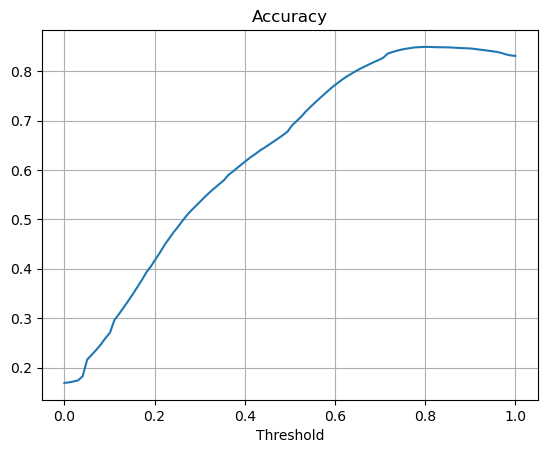

In [20]:
threshold_score['Accuracy'].plot(grid=True).set_title('Accuracy')

Text(0.5, 1.0, 'Balanced Accuracy')

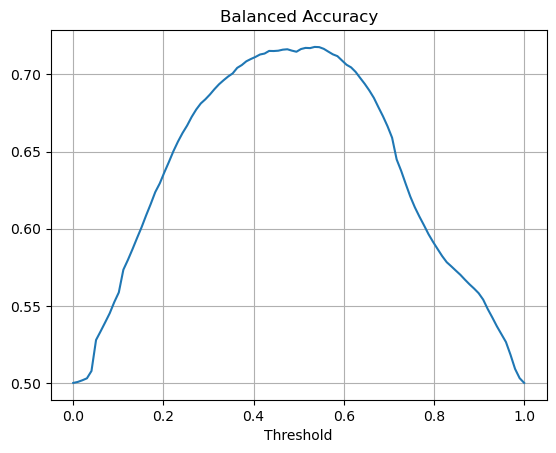

In [21]:
threshold_score['Balanced Accuracy'].plot(grid=True).set_title('Balanced Accuracy')

In [22]:
threshold_score.iloc[threshold_score['Balanced Accuracy'].argmax()]

Accuracy             0.718624
Balanced Accuracy    0.717865
Precision P          0.341200
Recall P             0.716719
F1 score P           0.462312
Precision N          0.925928
Recall N             0.719011
F1 score N           0.809455
Name: 0.5353535353535354, dtype: float64

In [23]:
thred = threshold_score.iloc[threshold_score['Balanced Accuracy'].argmax()].name
thred

0.5353535353535354

Text(0.5, 1.0, 'Confusion matrix')

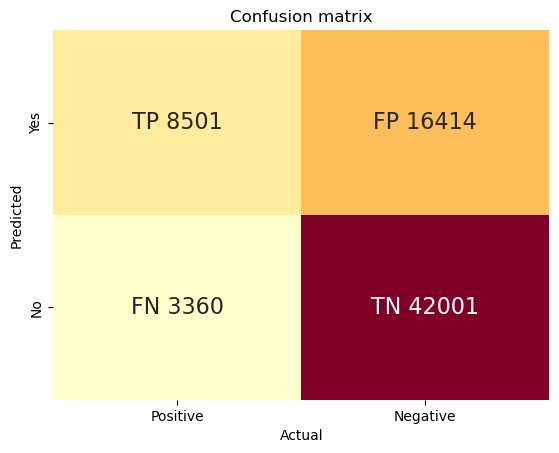

In [24]:
confusion_matrix = compute_confusion_matrix(test_label, prediction_proba, thred)
[[TP, FP],[FN, TN]] = confusion_matrix
label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                    ['FN {}'.format(FN), 'TN {}'.format(TN)]])

df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 

sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix')

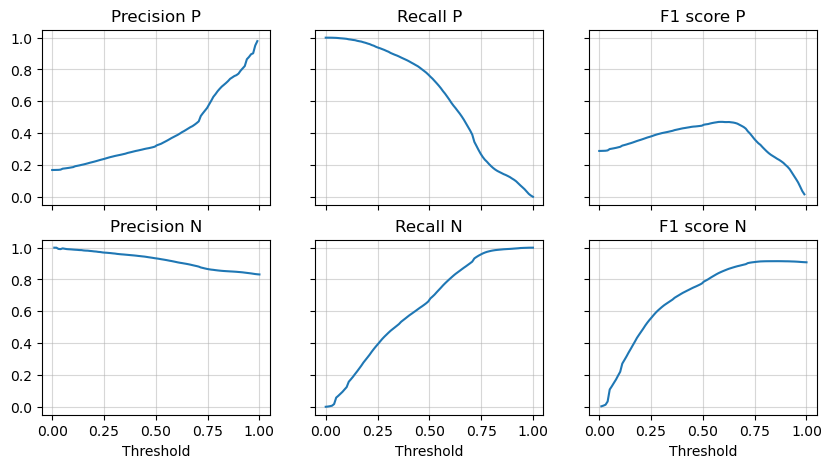

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10,5))

col_plot = ['Precision P', 'Recall P', 'F1 score P', 'Precision N', 'Recall N', 'F1 score N']

major_ticks = np.linspace(0,1,5)

for axe, col in zip(axs.flat, col_plot):
    threshold_score[col].plot(ax=axe, grid = True)
    axe.set_title(col)
    axe.set_xticks(major_ticks)    
    axe.grid(which='major', alpha=0.5)